<a href="https://colab.research.google.com/github/AlonsoCarr/Repositorio_IA_Alonso/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
#Producto Integrador de Aprendizaje
#Nombre: Alonso Carrizales Mancilla
#Matrícula: 2001625
#Hora: N4

In [306]:
import zipfile
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [208]:
!pip install kaggle
from google.colab import files

In [209]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alonsocarrizales","key":"f45e16a7de58062a80df8e25a734ae8e"}'}

In [210]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [211]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 782M/788M [00:14<00:00, 67.0MB/s]
100% 788M/788M [00:14<00:00, 56.4MB/s]


In [307]:
# Ruta al archivo ZIP descargado
zip_file_path = '/content/microsoft-catsvsdogs-dataset.zip'

# Ruta a la carpeta donde deseas descomprimir el archivo
extracted_folder_path = '/content/Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [213]:
def eliminar_imagenes_baja_resolucion(carpeta_principal, min_ancho=32, min_alto=32):
    # Contador de imágenes eliminadas
    imagenes_eliminadas = 0

    # Recorrer todas las subcarpetas
    for root, dirs, files in os.walk(carpeta_principal):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is not None:
                    alto, ancho, _ = image.shape
                    if ancho < min_ancho or alto < min_alto:
                        # Eliminar la imagen si su resolución es inferior a min_ancho x min_alto
                        os.remove(file_path)
                        #print(f"Imagen eliminada: {file_path} - Resolución: {ancho}x{alto}")
                        imagenes_eliminadas += 1

    print(f"Total de imágenes eliminadas: {imagenes_eliminadas}")

# Especifica la ruta de la carpeta principal
carpeta_principal = '/content/Dataset/PetImages'

# Llama a la función para eliminar imágenes con baja resolución
eliminar_imagenes_baja_resolucion(carpeta_principal)


Total de imágenes eliminadas: 1


In [214]:
def encontrar_resolucion_minima(carpeta_principal):
    min_ancho = float('inf')
    min_alto = float('inf')
    min_resolucion = None

    # Recorrer todas las subcarpetas
    for root, dirs, files in os.walk(carpeta_principal):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is not None:
                    alto, ancho, _ = image.shape
                    if ancho < min_ancho and alto < min_alto:
                        min_ancho = ancho
                        min_alto = alto
                        min_resolucion = (ancho, alto)

    return min_resolucion

# Especifica la ruta de la carpeta principal
carpeta_principal = '/content/Dataset/PetImages'

# Llama a la función para encontrar la resolución mínima
resolucion_minima = encontrar_resolucion_minima(carpeta_principal)

if resolucion_minima:
    print(f"La resolución mínima encontrada es: {resolucion_minima[0]}x{resolucion_minima[1]}")
else:
    print("No se encontraron imágenes en la carpeta.")


La resolución mínima encontrada es: 42x63


In [215]:
# Ruta de la carpeta principal que contiene las subcarpetas con imágenes
main_folder = '/content/Dataset/PetImages'
# Ruta de la carpeta donde se guardarán las imágenes reescaladas
output_folder = '/content/Imagenes'

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Tamaño al que se reescalarán las imágenes
nuevo_tamano = (32, 32)

# Iterar sobre las subcarpetas dentro de la carpeta principal
for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)

    # Verificar si es una carpeta
    if os.path.isdir(folder_path):
        # Buscar el índice del primer guion medio
        index = folder_name.find('-')

        # Si se encuentra guion medio, eliminar todo antes del guion medio, incluyendo el guion medio
        if index != -1:
            output_subfolder_name = folder_name[index + 1:]
        else:
            output_subfolder_name = folder_name  # Conservar el nombre original

        output_subfolder = os.path.join(output_folder, output_subfolder_name)

        # Crear la subcarpeta de salida si no existe
        os.makedirs(output_subfolder, exist_ok=True)

        # Iterar sobre los archivos de imagen dentro de la subcarpeta
        for file_path in glob.iglob(f'{folder_path}/*.jpg'):
            # Leer la imagen a color
            test_image = cv2.imread(file_path, cv2.IMREAD_COLOR)

            # Verificar si la imagen se leyó correctamente
            if test_image is not None:
                # Reescalar la imagen
                img_resized = cv2.resize(test_image, nuevo_tamano)

                # Obtener el nombre del archivo
                file_name = os.path.basename(file_path)

                # Guardar la imagen reescalada en la subcarpeta correspondiente en la carpeta de salida
                output_file_path = os.path.join(output_subfolder, file_name)
                cv2.imwrite(output_file_path, img_resized)

print("Reescalado y guardado de imágenes completado.")


Reescalado y guardado de imágenes completado.


Tamaño del conjunto de entrenamiento: 19956
Tamaño del conjunto de prueba: 4989


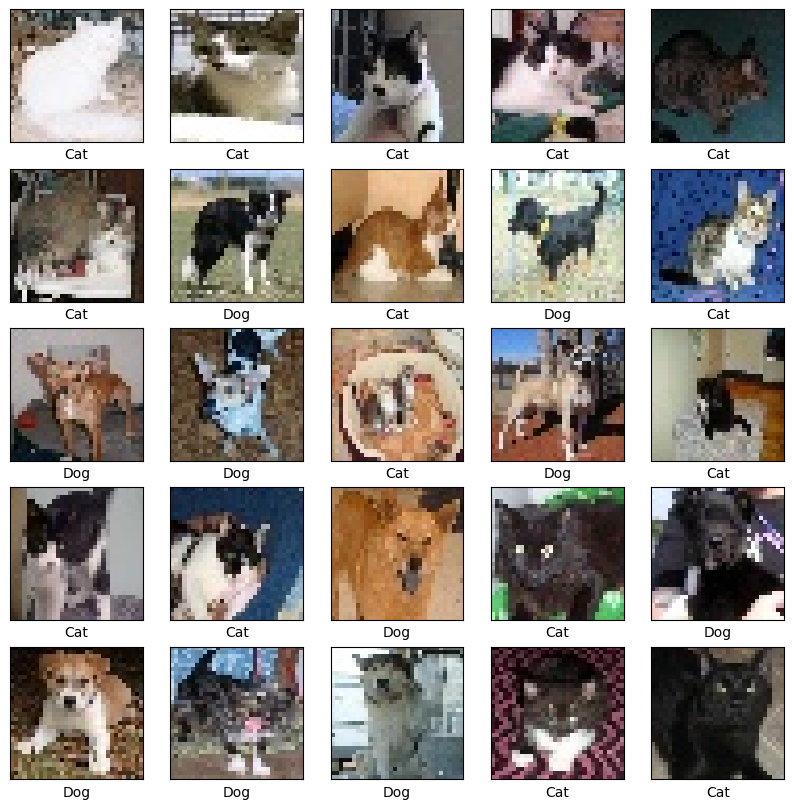

In [216]:
# Ruta de la carpeta principal
carpeta_principal = '/content/Imagenes'

# Patrón para encontrar todas las subcarpetas dentro de la carpeta principal
patron = os.path.join(carpeta_principal, '*')

# Utiliza glob para encontrar todas las subcarpetas que coinciden con el patrón
subcarpetas = glob.glob(patron)

imagenes = []
etiquetas = []
class_names = []

# Itera sobre las subcarpetas encontradas
for subcarpeta in subcarpetas:
    if os.path.isdir(subcarpeta):
        # Obtener el nombre de la subcarpeta
        nombre_subcarpeta = os.path.basename(subcarpeta)
        class_names.append(nombre_subcarpeta)

        # Obtener todas las imágenes en la subcarpeta
        archivos_imagenes = glob.glob(f'{subcarpeta}/*.jpg')
        for x in archivos_imagenes:
            test_image = cv2.imread(x)

            # Verificar si la imagen se leyó correctamente
            if test_image is None:
                print(f"Error al leer la imagen {x}")
                continue

            # Convertir la imagen de BGR a RGB
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

            # Formato de imagen
            img_resized = cv2.resize(test_image, (32, 32))

            # Guardar imagenes y etiquetas
            arreglo_imagen = np.array(img_resized)
            imagenes.append(arreglo_imagen)
            etiquetas.append(nombre_subcarpeta)

# Verificar que ambas listas tengan la misma longitud
if len(imagenes) != len(etiquetas):
    raise ValueError(f"Desajuste: {len(imagenes)} imágenes y {len(etiquetas)} etiquetas")

# Convertir etiquetas a índices numéricos
label_to_index = {label: index for index, label in enumerate(class_names)}
numeric_labels = np.array([label_to_index[label] for label in etiquetas])


# Convertir listas a arrays numpy y normalizar imágenes
etiquetas = np.array(numeric_labels)
images = np.array(imagenes)


# Dividir en conjuntos de entrenamiento y prueba
images_train, images_test, labels_train, labels_test = train_test_split(images, etiquetas, test_size=0.2, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {len(images_train)}')
print(f'Tamaño del conjunto de prueba: {len(images_test)}')

# Visualización
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i])
    plt.xlabel(class_names[labels_train[i]])
plt.show()

In [217]:
# Uso de transferencia de aprendizaje con VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Congelar las capas convolucionales

In [218]:
np.shape(imagenes)

(24945, 32, 32, 3)

In [219]:
len(etiquetas)

24945

In [220]:
etiquetas[-1]

1

In [221]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [222]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_6 (Flatten)         (None, 1024)             

In [223]:
print(len(images_train))
print(len(labels_train))

19956
19956


In [224]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [242]:
# Aumento de datos
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [262]:
train_generator = data_augmentation.flow(images_train, labels_train, batch_size=64)
history = model.fit(images_train, labels_train, epochs=10, validation_data=(images_test, labels_test))

Epoch 1/10
624/624 [==============================] - 33s 54ms/step - loss: 0.0592 - accuracy: 0.9803 - val_loss: 1.3642 - val_accuracy: 0.7513
Epoch 2/10
624/624 [==============================] - 31s 49ms/step - loss: 0.0562 - accuracy: 0.9824 - val_loss: 1.5127 - val_accuracy: 0.7651
Epoch 3/10
624/624 [==============================] - 33s 53ms/step - loss: 0.0431 - accuracy: 0.9859 - val_loss: 1.8473 - val_accuracy: 0.7543
Epoch 4/10
624/624 [==============================] - 31s 49ms/step - loss: 0.0489 - accuracy: 0.9849 - val_loss: 1.9192 - val_accuracy: 0.7472
Epoch 5/10
624/624 [==============================] - 31s 49ms/step - loss: 0.0621 - accuracy: 0.9797 - val_loss: 1.8994 - val_accuracy: 0.7274
Epoch 6/10
624/624 [==============================] - 32s 51ms/step - loss: 0.0560 - accuracy: 0.9821 - val_loss: 1.8293 - val_accuracy: 0.7535
Epoch 7/10
624/624 [==============================] - 31s 49ms/step - loss: 0.0466 - accuracy: 0.9844 - val_loss: 2.0426 - val_accuracy:

156/156 - 3s - loss: 1.8763 - accuracy: 0.7545 - 3s/epoch - 22ms/step


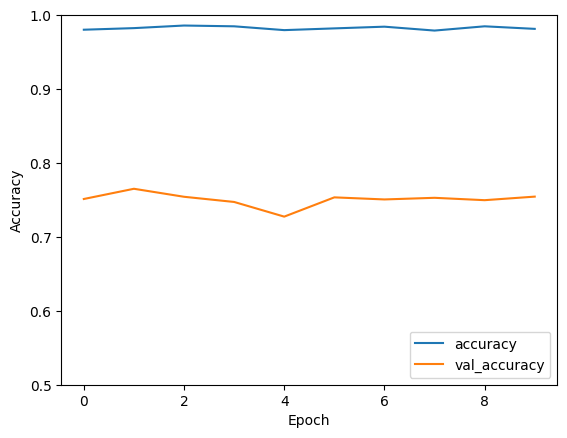

In [263]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images_test,  labels_test, verbose=2)

In [264]:
print(test_acc)

0.754459798336029


In [265]:
predictions = model.predict(images_test)

156/156 [==============================] - 3s 18ms/step


In [266]:
predictions[0]

array([29.524233, 35.77135 ], dtype=float32)

In [267]:
np.argmax(predictions[0])

1

In [268]:
labels_test[0]

1

In [296]:
# Definir la función plot_value_array
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(2), class_names)
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([min(predictions_array) - 0.1, 1])  # Ajustar los límites del eje y para mostrar números negativos
    predicted_label = np.argmax(predictions_array)

    # Colorear solo la barra de la predicción de la IA
    if predicted_label == true_label:
        thisplot[predicted_label].set_color('blue')
    else:
        thisplot[predicted_label].set_color('red')

    # Agregar línea horizontal en el eje 0
    plt.axhline(0, color='black', linewidth=0.5)

    # Agregar etiqueta "0" en el eje y
    plt.text(-0.5, 0, '0', ha='right', va='center', color='black')

# Definir la función plot_image para referencia
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% ({class_names[true_label]})", color=color)

Predicción 1

Tamaño de imagen:
(32, 32, 3)

Única imagen:
(1, 32, 32, 3)

1/1 [==============================] - 0s 42ms/step
Predicción:
[[29.524239 35.77136 ]]

Número de etiqueta:


1

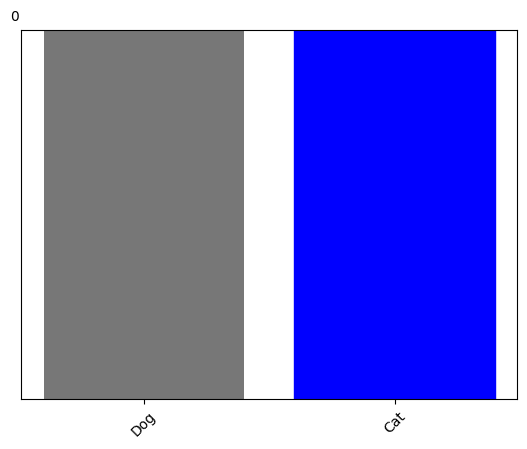

In [299]:
# Predicción de Imagenes
print('Predicción 1')
print('')

img = images_test[0]
print('Tamaño de imagen:')
print(img.shape)
print('')

img = np.expand_dims(img, 0)
print('Única imagen:')
print(img.shape)
print('')

predictions_single = model.predict(img)
print('Predicción:')
print(predictions_single)
print('')

# Llamar a la función plot_value_array
plot_value_array(0, predictions_single[0], labels_test)
_ = plt.xticks(range(2), class_names, rotation=45)

print('Número de etiqueta:')
np.argmax(predictions_single[0])



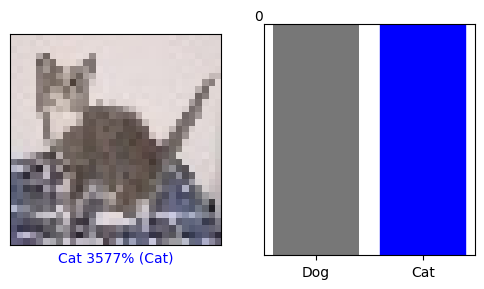

In [293]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], labels_test, images_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels_test)
plt.show()

Predicción 2

Tamaño de imagen:
(32, 32, 3)

Única imagen:
(1, 32, 32, 3)

1/1 [==============================] - 0s 24ms/step
Predicción:
[[-14.323487 -20.180887]]

Número de etiqueta:


0

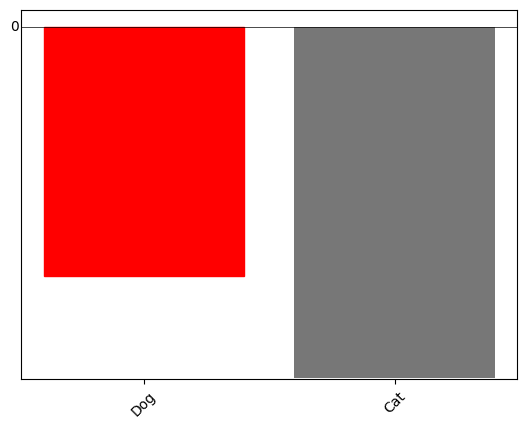

In [297]:
# Predicción de Imagenes
print('Predicción 2')
print('')

img = images_test[1]
print('Tamaño de imagen:')
print(img.shape)
print('')

img = np.expand_dims(img, 0)
print('Única imagen:')
print(img.shape)
print('')

predictions_single = model.predict(img)
print('Predicción:')
print(predictions_single)
print('')

# Llamar a la función plot_value_array
plot_value_array(1, predictions_single[0], labels_test)
_ = plt.xticks(range(2), class_names, rotation=45)

print('Número de etiqueta:')
np.argmax(predictions_single[0])



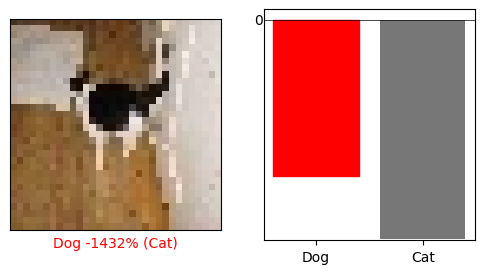

In [298]:
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], labels_test, images_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels_test)
plt.show()

Predicción 3

Tamaño de imagen:
(32, 32, 3)

Única imagen:
(1, 32, 32, 3)

1/1 [==============================] - 0s 25ms/step
Predicción:
[[50.032642 87.321526]]

Número de etiqueta:


1

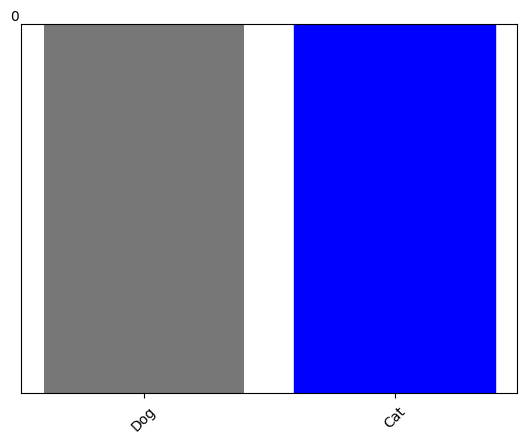

In [300]:
# Predicción de Imagenes
print('Predicción 3')
print('')

img = images_test[2]
print('Tamaño de imagen:')
print(img.shape)
print('')

img = np.expand_dims(img, 0)
print('Única imagen:')
print(img.shape)
print('')

predictions_single = model.predict(img)
print('Predicción:')
print(predictions_single)
print('')

# Llamar a la función plot_value_array
plot_value_array(2, predictions_single[0], labels_test)
_ = plt.xticks(range(2), class_names, rotation=45)

print('Número de etiqueta:')
np.argmax(predictions_single[0])



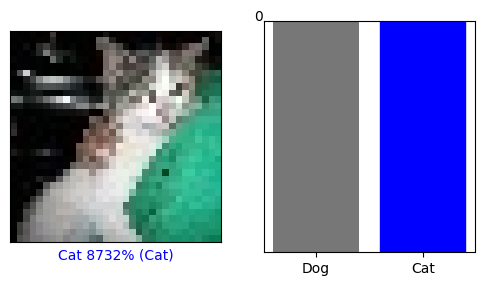

In [301]:
i = 2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], labels_test, images_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels_test)
plt.show()

Predicción 4

Tamaño de imagen:
(32, 32, 3)

Única imagen:
(1, 32, 32, 3)

1/1 [==============================] - 0s 140ms/step
Predicción:
[[ 1.3765494  -0.78614074]]

Número de etiqueta:


0

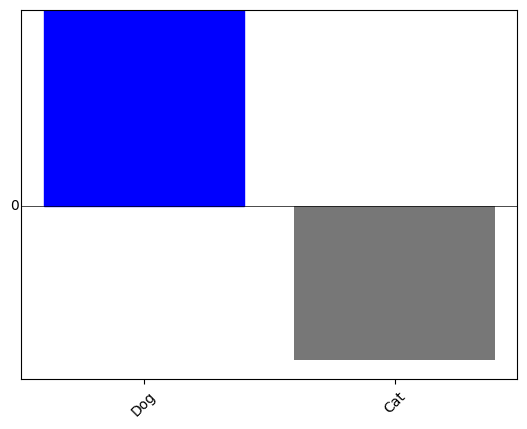

In [302]:
# Predicción de Imagenes
print('Predicción 4')
print('')

img = images_test[3]
print('Tamaño de imagen:')
print(img.shape)
print('')

img = np.expand_dims(img, 0)
print('Única imagen:')
print(img.shape)
print('')

predictions_single = model.predict(img)
print('Predicción:')
print(predictions_single)
print('')

# Llamar a la función plot_value_array
plot_value_array(3, predictions_single[0], labels_test)
_ = plt.xticks(range(2), class_names, rotation=45)

print('Número de etiqueta:')
np.argmax(predictions_single[0])


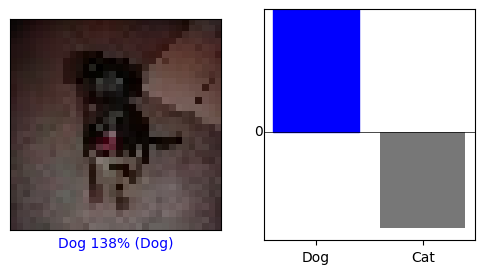

In [303]:
i = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], labels_test, images_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels_test)
plt.show()

Predicción 5

Tamaño de imagen:
(32, 32, 3)

Única imagen:
(1, 32, 32, 3)

1/1 [==============================] - 0s 35ms/step
Predicción:
[[ -9.211703 -20.066944]]

Número de etiqueta:


0

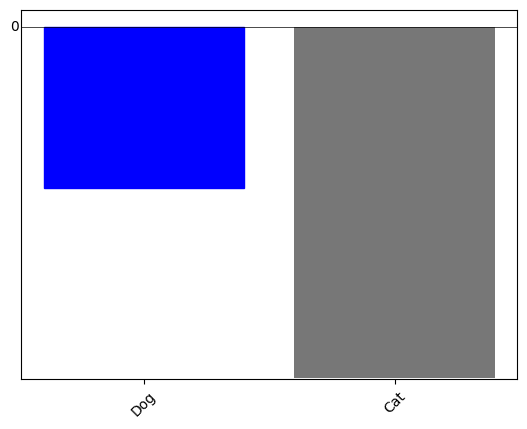

In [304]:
# Predicción de Imagenes
print('Predicción 5')
print('')

img = images_test[4]
print('Tamaño de imagen:')
print(img.shape)
print('')

img = np.expand_dims(img, 0)
print('Única imagen:')
print(img.shape)
print('')

predictions_single = model.predict(img)
print('Predicción:')
print(predictions_single)
print('')

# Llamar a la función plot_value_array
plot_value_array(4, predictions_single[0], labels_test)
_ = plt.xticks(range(2), class_names, rotation=45)

print('Número de etiqueta:')
np.argmax(predictions_single[0])


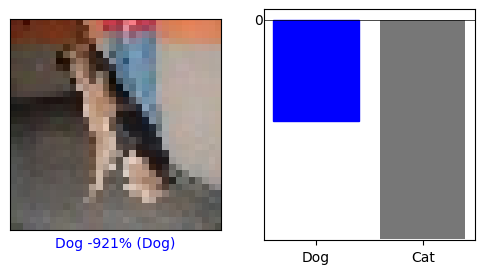

In [305]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], labels_test, images_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels_test)
plt.show()